In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#root_path = 'gdrive/My Drive/NumtaDB_with_aug' 

In [2]:
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import keras
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation,Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.utils import to_categorical
from keras import backend as k
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
from keras.models import Sequential
from keras.initializers import TruncatedNormal
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [5]:
pip install keras-tuner


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [6]:
import keras_tuner as kt

In [7]:
#Declaring constants
FIG_WIDTH=20 # Width of figure
HEIGHT_PER_ROW=3 # Height of each row when showing a figure which consists of multiple rows
RESIZE_DIM=32 # The images will be resized to 28x28 pixels


In [11]:
#data_dir=os.path.join('/content/gdrive/MyDrive/NumtaDB_with_aug')
data_dir=os.path.join('.','NumtaDB_with_aug')
paths_train_a=glob.glob(os.path.join(data_dir,'training-a','*.png'))
paths_train_b=glob.glob(os.path.join(data_dir,'training-b','*.png'))
paths_train_e=glob.glob(os.path.join(data_dir,'training-e','*.png'))
paths_train_c=glob.glob(os.path.join(data_dir,'training-c','*.png'))
paths_train_d=glob.glob(os.path.join(data_dir,'training-d','*.png'))
paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e

paths_test_a=glob.glob(os.path.join(data_dir,'testing-a','*.png'))
paths_test_b=glob.glob(os.path.join(data_dir,'testing-b','*.png'))
paths_test_e=glob.glob(os.path.join(data_dir,'testing-e','*.png'))
paths_test_c=glob.glob(os.path.join(data_dir,'testing-c','*.png'))
paths_test_d=glob.glob(os.path.join(data_dir,'testing-d','*.png'))
paths_test_f=glob.glob(os.path.join(data_dir,'testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.JPG'))
paths_test_auga=glob.glob(os.path.join(data_dir,'testing-auga','*.png'))
paths_test_augc=glob.glob(os.path.join(data_dir,'testing-augc','*.png'))
paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

path_label_train_a=os.path.join(data_dir,'training-a.csv')
path_label_train_b=os.path.join(data_dir,'training-b.csv')
path_label_train_e=os.path.join(data_dir,'training-e.csv')
path_label_train_c=os.path.join(data_dir,'training-c.csv')
path_label_train_d=os.path.join(data_dir,'training-d.csv')

In [12]:
def get_key(path):
    # seperates the key of an image from the filepath
    key=path.split(sep=os.sep)[-1]
    return key

def get_data(paths_img,path_label=None,resize_dim=None):
    '''reads images from the filepaths, resizes them (if given), and returns them in a numpy array
    Args:
        paths_img: image filepaths
        path_label: pass image label filepaths while processing training data, defaults to None while processing testing data
        resize_dim: if given, the image is resized to resize_dim x resize_dim (optional)
    Returns:
        X: group of images
        y: categorical true labels
    '''
    X=[] # initialize empty list for resized images
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE) # images loaded in color (BGR)
        #img = cv2.bilateralFilter(img,9,75,75)
        #img = cv2.medianBlur(img,5)
        #img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
        #img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # cnahging colorspace to GRAY
        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA) # resize image to 28x28
        #X.append(np.expand_dims(img,axis=2)) # expand image to 28x28x1 and append to the list.
        gaussian_3 = cv2.GaussianBlur(img, (9,9), 10.0) #unblur
        img = cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) #filter
        img = cv2.filter2D(img, -1, kernel)
        #thresh = 200
        #maxValue = 255
        #th, img = cv2.threshold(img, thresh, maxValue, cv2.THRESH_BINARY);
        ret,img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        X.append(img) # expand image to 28x28x1 and append to the list
        # display progress
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)
        
    X=np.array(X) # tranform list to numpy array
    if  path_label is None:
        return X
    else:
        df = pd.read_csv(path_label) # read labels
        df=df.set_index('filename') 
        y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] # get the labels corresponding to the images
        y=to_categorical(y_label,10) # transfrom integer value to categorical variable
        return X, y
        
def imshow_group(X,y,y_pred=None,n_per_row=10,phase='processed'):
    '''helper function to visualize a group of images along with their categorical true labels (y) and prediction probabilities.
    Args:
        X: images
        y: categorical true labels
        y_pred: predicted class probabilities
        n_per_row: number of images per row to be plotted
        phase: If the images are plotted after resizing, pass 'processed' to phase argument. 
            It will plot the image and its true label. If the image is plotted after prediction 
            phase, pass predicted class probabilities to y_pred and 'prediction' to the phase argument. 
            It will plot the image, the true label, and it's top 3 predictions with highest probabilities.
    '''
    n_sample=len(X)
    img_dim=X.shape[1]
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,HEIGHT_PER_ROW*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
#         img_sq=np.squeeze(img,axis=2)
#         plt.imshow(img_sq,cmap='gray')
        plt.imshow(img)
        if phase=='processed':
            plt.title(np.argmax(y[i]))
        if phase=='prediction':
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
            if y is not None:
                plt.text(img_dim/2, -4, 'true label: {}'.format(np.argmax(y[i])), 
                         horizontalalignment='center',verticalalignment='center')
        plt.axis('off')
    plt.show()

In [13]:
X_train_a,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dim=RESIZE_DIM)
X_train_b,y_train_b=get_data(paths_train_b,path_label_train_b,resize_dim=RESIZE_DIM)
X_train_c,y_train_c=get_data(paths_train_c,path_label_train_c,resize_dim=RESIZE_DIM)
X_train_d,y_train_d=get_data(paths_train_d,path_label_train_d,resize_dim=RESIZE_DIM)
X_train_e,y_train_e=get_data(paths_train_e,path_label_train_e,resize_dim=RESIZE_DIM)

processed 19702/19702
processed 359/359
processed 24298/24298
processed 10908/10908
processed 16778/16778


In [14]:
X_train_all=np.concatenate((X_train_a,X_train_b,X_train_c,X_train_d,X_train_e),axis=0)
y_train_all=np.concatenate((y_train_a,y_train_b,y_train_c,y_train_d,y_train_e),axis=0)
X_train_all.shape, y_train_all.shape

((72045, 32, 32), (72045, 10))

In [15]:
X_show_all=X_train_all


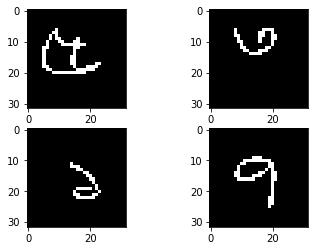

In [16]:
plt.subplot(221)
plt.imshow(X_train_all[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train_all[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train_all[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train_all[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

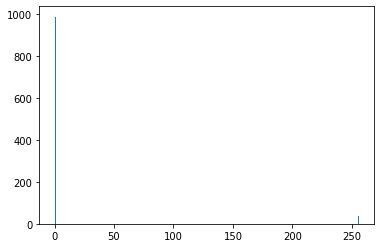

In [17]:
imgg=X_train_all[1]
hist = cv2.calcHist([imgg],[0],None,[256],[0,256])
plt.hist(imgg.ravel(),256,[0,256])
 
# show the plotting graph of an image

plt.show()

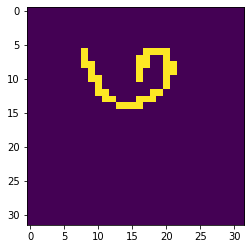

In [18]:
plt.imshow(X_train_all[1])

In [19]:
X_test_a=get_data(paths_test_a,resize_dim=RESIZE_DIM)
X_test_b=get_data(paths_test_b,resize_dim=RESIZE_DIM)
X_test_c=get_data(paths_test_c,resize_dim=RESIZE_DIM)
X_test_d=get_data(paths_test_d,resize_dim=RESIZE_DIM)
X_test_e=get_data(paths_test_e,resize_dim=RESIZE_DIM)
X_test_f=get_data(paths_test_f,resize_dim=RESIZE_DIM)
X_test_auga=get_data(paths_test_auga,resize_dim=RESIZE_DIM)
X_test_augc=get_data(paths_test_augc,resize_dim=RESIZE_DIM)

processed 3489/3489
processed 69/69
processed 4381/4381
processed 1948/1948
processed 2970/2970
processed 495/495
processed 2168/2168
processed 2106/2106


In [20]:
X_test_all=np.concatenate((X_test_a,X_test_b,X_test_c,X_test_d,X_test_e,X_test_f,X_test_auga,X_test_augc))

In [21]:
X_tshow_all=X_test_all
X_tshow_all.shape

(17626, 32, 32)

In [22]:
X_train_all = X_train_all.reshape(X_train_all.shape[0],32, 32,1).astype('float32')
X_test_all = X_test_all.reshape(X_test_all.shape[0],32, 32,1).astype('float32')

In [23]:
X_train_all.shape

(72045, 32, 32, 1)

In [24]:
X_train_all = X_train_all/255
X_test_all=X_test_all/255

In [25]:
indices=list(range(len(X_train_all)))
np.random.seed(42)
np.random.shuffle(indices)

ind=int(len(indices)*0.80)
# train data
X_train=X_train_all[indices[:ind]] 
y_train=y_train_all[indices[:ind]]
# validation data
X_val=X_train_all[indices[-(len(indices)-ind):]] 
y_val=y_train_all[indices[-(len(indices)-ind):]]

In [45]:
############## HyperBand starts ############
from kerastuner.tuners import Hyperband

from keras.layers.normalization.batch_normalization import BatchNormalization
def model_builder(hp):
  model = Sequential()

  
  model.add(Conv2D(
      filters=hp.Int('num_filters_1', min_value=32, max_value=512, step = 32, default = 32), 
      activation='relu', 
      kernel_size=hp.Choice('kernel_1', values=[2,3,4,5], default = 3),
      padding='same', 
      kernel_initializer='TruncatedNormal', 
      input_shape=(32, 32, 1)))
  
  model.add(Conv2D(
      filters=hp.Int('num_filters_2', min_value=32, max_value=512, step = 32, default = 32),
      activation='relu', 
      kernel_size=hp.Choice('kernel_2', values=[2,3,4,5], default = 3),
      padding='same', 
      kernel_initializer='TruncatedNormal')) 
  
  model.add(MaxPooling2D(pool_size=(2, 2)))

  
  model.add(Conv2D(
      filters=hp.Int('num_filters_3', min_value=32, max_value=512, step = 32, default = 32),
      activation='relu', 
      kernel_size=hp.Choice('kernel_3', values=[2,3,4,5], default = 3),
      padding='same', 
      kernel_initializer='TruncatedNormal'))
  
  model.add(Conv2D(
      filters=hp.Int('num_filters_4', min_value=32, max_value=512, step = 32, default = 32),
      activation='relu', 
      kernel_size=hp.Choice('kernel_4', values=[2,3,4,5], default = 3),
      padding='same', 
      kernel_initializer='TruncatedNormal'))
  
  model.add(MaxPooling2D(pool_size=(2, 2)))
    
  model.add(Flatten())

  model.add(Dense(
      units=hp.Int('dense_units_1', min_value=32, max_value=512, step = 32, default = 32), 
      activation='relu', 
      kernel_initializer='TruncatedNormal'))

  model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.3, step=0.1)))

  model.add(Dense(
      units=hp.Int('dense_units_2', min_value=32, max_value=512, step = 32, default = 32),
      activation='relu', 
      kernel_initializer='TruncatedNormal'))

  model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.3, step=0.1)))
  
  model.add(Dense(10, activation='sigmoid', kernel_initializer='TruncatedNormal'))
    
  #hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  hp_learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.binary_crossentropy,
                metrics=['accuracy'])
  model.summary()

  return model

In [46]:
### Hyperband


tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     #executions_per_trial=3,
                     directory='my_dir',
                     project_name='NUMTADB')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                  

In [49]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [50]:
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
160               |?                 |num_filters_1
2                 |?                 |kernel_1
192               |?                 |num_filters_2
2                 |?                 |kernel_2
384               |?                 |num_filters_3
5                 |?                 |kernel_3
224               |?                 |num_filters_4
3                 |?                 |kernel_4
288               |?                 |dense_units_1
0.4               |?                 |dropout_1
448               |?                 |dense_units_2
0.1               |?                 |dropout_2
0.0023171         |?                 |lr
3                 |?                 |tuner/epochs
0                 |?                 |tuner/initial_epoch
2                 |?                 |tuner/bracket
0                 |?                 |tuner/round

Model: "sequential"
___________________________________________________

KeyboardInterrupt: 

In [ ]:
tuner.results_summary()

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, validation_data=(X_val, y_val))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(img_train, label_train, epochs=best_epoch, validation_split=0.2)

In [ ]:
# Evaluate on validation set
score = hypermodel.evaluate(X_val, y_val, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = hypermodel.predict(X_val)
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
#score = hypermodel.evaluate(X_test_all, y_test_all, verbose=1)
#print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = hypermodel.predict(X_test_all)
fpr, tpr, _ = roc_curve(y_test_all, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)


############## HyperBand Ends ############

In [ ]:
predictions_prob=model.predict(X_test_all) # get predictions for all the test data

In [ ]:
n_sample=200
np.random.seed(42)
ind=np.random.randint(0,len(X_test_all), size=n_sample)

In [ ]:
imshow_group(X=X_tshow_all[ind],y=None,y_pred=predictions_prob[ind], phase='prediction')